In [1]:
import os
import sys
import pprint
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import ParameterGrid
import pprint
from itertools import chain


base_dir = 'F:\Thesis_ssd\MasterThesis3.0'
os.chdir(base_dir)

from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.DataProcessing.TimeAugmentor import TimeAugmentor
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Modeling.ResultFitter import ResultFitter
from Classes.Modeling.NarrowSearch import NarrowSearch
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
import json

helper = HelperFunctions()
%load_ext tensorboard

In [2]:
### Data conditions: ###
load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : True,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 0.3,
    'seed' : 1,
    'subsample_size' : 0.25,
    'balance_non_train_set' : True,
    'use_true_test_set' : False
}

loadData = LoadData(**load_args)

full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)
dataGen = DataGenerator(loadData)

if load_args['earth_explo_only']:
    full_and_noise_ds = np.concatenate((full_ds, noise_ds))
    timeAug = TimeAugmentor(handler, full_and_noise_ds, seed = load_args['seed'])
else:
    timeAug = TimeAugmentor(handler, full_ds, seed = load_args['seed'])

In [3]:
print(len(train_ds), len(val_ds), len(test_ds))
classes, counts = handler.get_class_distribution_from_ds(full_ds)
classes, counts = handler.get_class_distribution_from_ds(train_ds)
classes, counts = handler.get_class_distribution_from_ds(val_ds)
print("Nr noise samples " + str(len(loadData.noise_ds)))

21159 4231 2822
Total: 28212, earthquake: 9480, explosion: 9122, noise: 9610
Total: 21159, earthquake: 7153, explosion: 6817, noise: 7189
Total: 4231, earthquake: 1405, explosion: 1360, noise: 1466
Nr noise samples 7189


In [4]:

main_grid = {
            "num_channels" : [3],
            "num_layers" : [2],
            "batch_size" : [32],
            "epochs" : [40],
            "learning_rate" : [0.01],
            "optimizer" : ["sgd"],
            "start_neurons" : [32],
            "decay_sequence" : [[1,2,4,6,8,10]],
            "dropout_rate" : [0.3],
            "filters" : [17],
            "kernel_size" : [5],
            "padding" : ["same"],
            "use_layerwise_dropout_batchnorm" : [True],
            "l2_r" : [0.001],
            "l1_r" : [0.0001],
            "activation" : ["tanh"],
            "output_layer_activation" : ["sigmoid"]
           }

hyper_grid = {
        "num_channels" : [1,2],
        "num_layers" : [3,4,5,6],
        "batch_size" : [24, 28, 34, 36],
        "epochs" : [40],
        "learning_rate" : [0.1, 0.05, 0.025, 0.005],
        "optimizer" : ["sgd"]
    }
model_grid = {
    "start_neurons" : [24,28,30,34],
    "use_layerwise_dropout_batchnorm" : [False, True],
    "decay_sequence" : [[1,2,4,4,2,1], [1,4,8,8,4,1], [1,0.5,0.25,0.25,0.5,1], [1,1,1,1,1,1]],
    "dropout_rate" : [0.3, 0.25, 0.2, 0.15, 0.1],
    "filters" : [11],
    "kernel_size" : [5],
    "padding" : ["same"],
    "l2_r" : [0.005, 0.001, 0.0005, 0.0001, 0],
    "l1_r" : [0.0005, 0.0001, 0.00005],
    "activation" : ["tanh"],
    "output_layer_activation" : ["sigmoid"]
}


model_nr = "LSTM"

use_time_augmentor = True
use_scaler = True
use_noise_augmentor = True
detrend = False
use_minmax = False
use_highpass = False
highpass_freq = 0.1

use_tensorboard = False
use_liveplots = True
use_custom_callback = False
use_early_stopping = True
start_from_scratch = True

narrowSearch = NarrowSearch(loadData, train_ds, val_ds, test_ds, model_nr, detrend, use_scaler, use_time_augmentor, 
                                    use_noise_augmentor, use_minmax, use_highpass, main_grid, hyper_grid, 
                                    model_grid, use_tensorboard = use_tensorboard,use_liveplots = use_liveplots, 
                                    use_custom_callback = use_custom_callback, use_early_stopping = use_early_stopping, 
                                    highpass_freq = highpass_freq, start_from_scratch = start_from_scratch)

In [5]:
def clear_tensorboard_dir():
    import os
    import shutil
    path = f"{base_dir}/Tensorboard_dir/fit"
    files = os.listdir(path)
    print(files)
    for f in files:
        shutil.rmtree(os.path.join(path,f))
if use_tensorboard:
    clear_tensorboard_dir()
    %tensorboard --logdir tensorboard_dir/fit

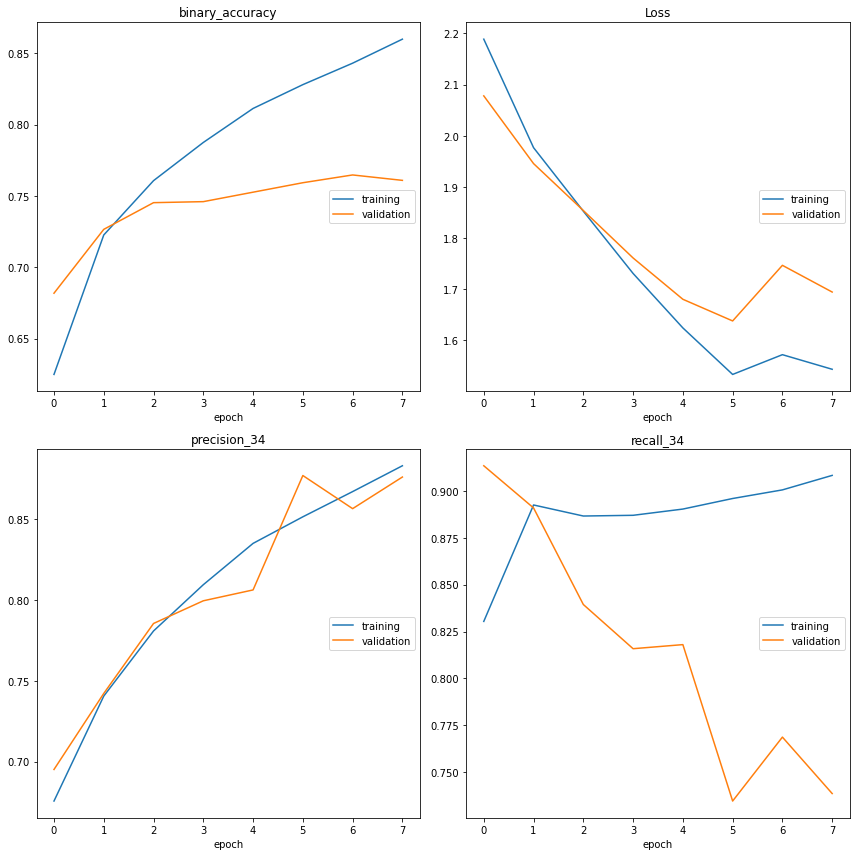

binary_accuracy
	training         	 (min:    0.625, max:    0.860, cur:    0.860)
	validation       	 (min:    0.682, max:    0.765, cur:    0.761)
Loss
	training         	 (min:    1.533, max:    2.189, cur:    1.544)
	validation       	 (min:    1.638, max:    2.078, cur:    1.694)
precision_34
	training         	 (min:    0.676, max:    0.883, cur:    0.883)
	validation       	 (min:    0.695, max:    0.877, cur:    0.876)
recall_34
	training         	 (min:    0.830, max:    0.908, cur:    0.908)
	validation       	 (min:    0.735, max:    0.913, cur:    0.739)
661/661 [==============================] - 66s 100ms/step - loss: 1.5435 - precision_34: 0.8828 - binary_accuracy: 0.8598 - recall_34: 0.9082 - val_loss: 1.6945 - val_precision_34: 0.8758 - val_binary_accuracy: 0.7609 - val_recall_34: 0.7387
Epoch 9/40
624/661 [===========================>..] - ETA: 3s - loss: 1.5009 - precision_34: 0.8839 - binary_accuracy: 0.8590 - recall_34: 0.9055

In [ ]:
results_df, min_loss, max_accuracy, max_precision, max_recall = narrowSearch.fit()